<font size="6"><b>MLP Neural Networks - Part I</b></font>

![Figure_13](img/Figure_13.png)

# Libraries

In [174]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import xgboost as xgb
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)
import datetime, warnings, scipy
warnings.filterwarnings("ignore")

import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Conv2D , SeparableConv2D, MaxPool2D, Flatten , Dropout , BatchNormalization
from keras import Sequential
from keras.layers import Dense
from sklearn import preprocessing
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow import keras

# Data Loading

In [2]:
dfm_ready = pd.read_csv('dfm_ready.csv', index_col=0)
dfm_ready.head().append(dfm_ready.tail())

,DEP_DELAY,CRS_ELAPSED_TIME,AIR_TIME,DISTANCE,FLIGHT_STATUS,OP_CARRIER_Allegiant Air,OP_CARRIER_American Airlines,OP_CARRIER_Delta Airlines,OP_CARRIER_Endeavor Air,OP_CARRIER_Envoy Air,OP_CARRIER_ExpressJet,OP_CARRIER_Frontier Airlines,OP_CARRIER_Hawaiian Airlines,OP_CARRIER_JetBlue Airways,OP_CARRIER_Mesa Airline,OP_CARRIER_PSA Airlines,OP_CARRIER_Republic Airways,OP_CARRIER_SkyWest Airlines,OP_CARRIER_Southwest Airlines,OP_CARRIER_Spirit Airlines,OP_CARRIER_United Airlines,OP_CARRIER_Virgin America,DEST_Atlanta,DEST_Boston,DEST_Charlotte,DEST_Chicago,DEST_Dallas-Fort Worth,DEST_Denver,DEST_Detroit,DEST_Houston,DEST_Las Vegas,DEST_Los Angeles,DEST_Minneapolis,DEST_New York,DEST_Newark,DEST_Orlando,DEST_Philadelphia,DEST_Phoenix,DEST_Salt Lake City,DEST_San Francisco,DEST_Seattle,CRS_DEP_TIME_2,CRS_DEP_TIME_3,CRS_DEP_TIME_4,CRS_ARR_TIME_2,CRS_ARR_TIME_3,CRS_ARR_TIME_4,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6
0,-5.0,268.0,225.0,1605.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-8.0,99.0,65.0,414.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-5.0,134.0,106.0,846.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6.0,190.0,157.0,1120.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,-3.0,206.0,173.0,1222.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7213439,31.0,182.0,142.0,1303.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7213440,-1.0,84.0,46.0,331.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7213441,-4.0,100.0,72.0,331.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7213442,6.0,181.0,148.0,936.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7213445,8.0,71.0,44.0,130.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


The next cell will make sure that all my features are in floating format, followed by a double check with the .info() function

In [3]:
df = dfm_ready.astype(float)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4008257 entries, 0 to 7213445
Data columns (total 64 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   DEP_DELAY                      float64
 1   CRS_ELAPSED_TIME               float64
 2   AIR_TIME                       float64
 3   DISTANCE                       float64
 4   FLIGHT_STATUS                  float64
 5   OP_CARRIER_Allegiant Air       float64
 6   OP_CARRIER_American Airlines   float64
 7   OP_CARRIER_Delta Airlines      float64
 8   OP_CARRIER_Endeavor Air        float64
 9   OP_CARRIER_Envoy Air           float64
 10  OP_CARRIER_ExpressJet          float64
 11  OP_CARRIER_Frontier Airlines   float64
 12  OP_CARRIER_Hawaiian Airlines   float64
 13  OP_CARRIER_JetBlue Airways     float64
 14  OP_CARRIER_Mesa Airline        float64
 15  OP_CARRIER_PSA Airlines        float64
 16  OP_CARRIER_Republic Airways    float64
 17  OP_CARRIER_SkyWest Airlines    float64
 18  OP

==================================================================================

# Function Library

This is a quick parenthesis to write down a few functions that I will be using to evaluate every model once finish training it. 

In [193]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('LOSS', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('ACCURACY', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.show()

In [182]:
def conf_matrix(conf_mat,):
    
    conf_mat = pd.DataFrame(conf_mat, index = ['0', '1'], columns = ['0', '1'])
    sns.set(font_scale=1.4)
    plt.figure(figsize = (8,7))
    sns.heatmap(conf_mat, cmap= "Blues", linecolor = 'black' , linewidth = 1, annot = True, fmt='')
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('True', fontsize=14)
    plt.show()

In [163]:
def model_metrics(a, b):
    
    accuracy = metrics.accuracy_score(a, b)
    precision = precision_score(a, b)
    recall = recall_score(a, b)
    f1 = f1_score(a, b)

    print('Accuracy:', round(accuracy*100, 2),'%')
    print('Precision score:', round(precision*100, 2),'%')
    print('Recall score:', round(recall*100, 2),'%')
    print('F1 score:', round(f1*100, 2),'%')

==================================================================================

Target (y) and Features (X) definitions:

In [45]:
y = df['FLIGHT_STATUS']
X = df.drop(['FLIGHT_STATUS', 'DEP_DELAY'], axis=1)

Notice that the models that will be trained on this Notebook have all the features available except for the FLIGHT_STATUS, which is our target, and the DEP_DELAY, to avoid biasing the model

In [47]:
df.head(2)

,DEP_DELAY,CRS_ELAPSED_TIME,AIR_TIME,DISTANCE,FLIGHT_STATUS,OP_CARRIER_Allegiant Air,OP_CARRIER_American Airlines,OP_CARRIER_Delta Airlines,OP_CARRIER_Endeavor Air,OP_CARRIER_Envoy Air,OP_CARRIER_ExpressJet,OP_CARRIER_Frontier Airlines,OP_CARRIER_Hawaiian Airlines,OP_CARRIER_JetBlue Airways,OP_CARRIER_Mesa Airline,OP_CARRIER_PSA Airlines,OP_CARRIER_Republic Airways,OP_CARRIER_SkyWest Airlines,OP_CARRIER_Southwest Airlines,OP_CARRIER_Spirit Airlines,OP_CARRIER_United Airlines,OP_CARRIER_Virgin America,DEST_Atlanta,DEST_Boston,DEST_Charlotte,DEST_Chicago,DEST_Dallas-Fort Worth,DEST_Denver,DEST_Detroit,DEST_Houston,DEST_Las Vegas,DEST_Los Angeles,DEST_Minneapolis,DEST_New York,DEST_Newark,DEST_Orlando,DEST_Philadelphia,DEST_Phoenix,DEST_Salt Lake City,DEST_San Francisco,DEST_Seattle,CRS_DEP_TIME_2,CRS_DEP_TIME_3,CRS_DEP_TIME_4,CRS_ARR_TIME_2,CRS_ARR_TIME_3,CRS_ARR_TIME_4,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6
0,-5.0,268.0,225.0,1605.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-8.0,99.0,65.0,414.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Neural Network Conditions

1. Data has to be purely numerical<br>
2. Data cannot contain missing values<br>
3. Data has to be Normalized<br>

In [189]:
df.isna().sum().sum()

0

We know the data is purely numerical and that it has no missing values, now all is needed is to normalized and we will do it by using the <b>StandardScaler</b>

In [50]:
col_names = list(df.columns)

s_scaler = preprocessing.StandardScaler()
df_s = s_scaler.fit_transform(df)

df_s = pd.DataFrame(df_s, columns=col_names)

The following are the two first rows of the normalized data:

In [51]:
df_s.head(2)

,DEP_DELAY,CRS_ELAPSED_TIME,AIR_TIME,DISTANCE,FLIGHT_STATUS,OP_CARRIER_Allegiant Air,OP_CARRIER_American Airlines,OP_CARRIER_Delta Airlines,OP_CARRIER_Endeavor Air,OP_CARRIER_Envoy Air,OP_CARRIER_ExpressJet,OP_CARRIER_Frontier Airlines,OP_CARRIER_Hawaiian Airlines,OP_CARRIER_JetBlue Airways,OP_CARRIER_Mesa Airline,OP_CARRIER_PSA Airlines,OP_CARRIER_Republic Airways,OP_CARRIER_SkyWest Airlines,OP_CARRIER_Southwest Airlines,OP_CARRIER_Spirit Airlines,OP_CARRIER_United Airlines,OP_CARRIER_Virgin America,DEST_Atlanta,DEST_Boston,DEST_Charlotte,DEST_Chicago,DEST_Dallas-Fort Worth,DEST_Denver,DEST_Detroit,DEST_Houston,DEST_Las Vegas,DEST_Los Angeles,DEST_Minneapolis,DEST_New York,DEST_Newark,DEST_Orlando,DEST_Philadelphia,DEST_Phoenix,DEST_Salt Lake City,DEST_San Francisco,DEST_Seattle,CRS_DEP_TIME_2,CRS_DEP_TIME_3,CRS_DEP_TIME_4,CRS_ARR_TIME_2,CRS_ARR_TIME_3,CRS_ARR_TIME_4,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6
0,-0.321419,1.534191,1.418987,1.176912,-0.768926,-0.081396,-0.435286,-0.442703,-0.180393,-0.187732,-0.159841,-0.126919,-0.036401,-0.212356,-0.159955,-0.187231,-0.217581,-0.332741,-0.406602,-0.164254,2.847426,-0.058525,-0.326623,-0.193125,-0.244507,-0.337433,-0.269893,4.021508,-0.200975,-0.245629,-0.203773,-0.240557,-0.202074,-0.278545,-0.18927,-0.194314,-0.170627,-0.215048,-0.169988,-0.212396,-0.189515,-0.789294,1.317508,-0.469889,-0.675979,1.355474,-0.666541,-0.279066,-0.301892,-0.301231,-0.306987,-0.308162,-0.31287,-0.313251,-0.298598,-0.307719,-0.297483,-0.298999,-0.409388,-0.411835,-0.417282,-0.418911,-0.371936,-0.405995
1,-0.384744,-0.703566,-0.754700,-0.729017,-0.768926,-0.081396,-0.435286,-0.442703,-0.180393,-0.187732,-0.159841,-0.126919,-0.036401,-0.212356,-0.159955,-0.187231,-0.217581,-0.332741,-0.406602,-0.164254,2.847426,-0.058525,-0.326623,-0.193125,-0.244507,-0.337433,-0.269893,-0.248663,-0.200975,-0.245629,-0.203773,-0.240557,-0.202074,-0.278545,-0.18927,-0.194314,-0.170627,-0.215048,-0.169988,4.708181,-0.189515,1.266955,-0.759008,-0.469889,-0.675979,1.355474,-0.666541,-0.279066,-0.301892,-0.301231,-0.306987,-0.308162,-0.31287,-0.313251,-0.298598,-0.307719,-0.297483,-0.298999,-0.409388,-0.411835,-0.417282,-0.418911,-0.371936,-0.405995


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Modeling

## Model 1

In [58]:
model_1 = Sequential()

model_1.add(Dense(30, activation='tanh', input_shape=(62,)))

model_1.add(Dense(1, activation='sigmoid'))

In [59]:
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [60]:
results1 = model_1.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

Train on 2885944 samples, validate on 320661 samples
Epoch 1/5
2885944/2885944 [==============================] - 120s 41us/step - loss: 0.6203 - acc: 0.6718 - val_loss: 0.6078 - val_acc: 0.6757
Epoch 2/5
2885944/2885944 [==============================] - 119s 41us/step - loss: 0.6113 - acc: 0.6778 - val_loss: 0.6079 - val_acc: 0.6874
Epoch 3/5
2885944/2885944 [==============================] - 121s 42us/step - loss: 0.6104 - acc: 0.6780 - val_loss: 0.6044 - val_acc: 0.6819
Epoch 4/5
2885944/2885944 [==============================] - 121s 42us/step - loss: 0.6101 - acc: 0.6787 - val_loss: 0.6072 - val_acc: 0.6833
Epoch 5/5
2885944/2885944 [==============================] - 118s 41us/step - loss: 0.6100 - acc: 0.6785 - val_loss: 0.6116 - val_acc: 0.6591


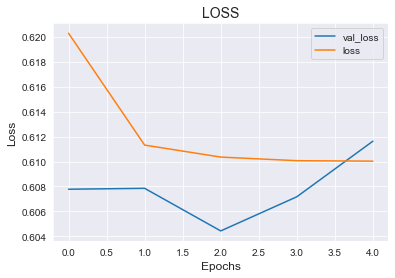

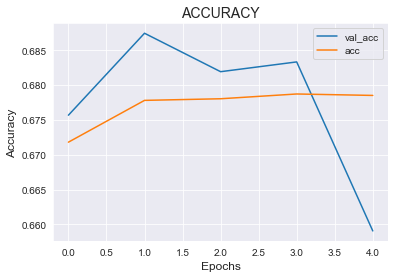

In [194]:
visualize_training_results(results1)

In [195]:
y_pred_m1 = model_1.predict(X_test)
y_pred_m1 =(y_pred_m1 > 0.5)

In [196]:
cm_m1 = confusion_matrix(y_test, y_pred_m1)
print(cm_m1)
print("------------------")
print(classification_report(y_test, y_pred_m1))

[[501262   2155]
 [271985  26250]]
------------------
              precision    recall  f1-score   support

         0.0       0.65      1.00      0.79    503417
         1.0       0.92      0.09      0.16    298235

    accuracy                           0.66    801652
   macro avg       0.79      0.54      0.47    801652
weighted avg       0.75      0.66      0.55    801652



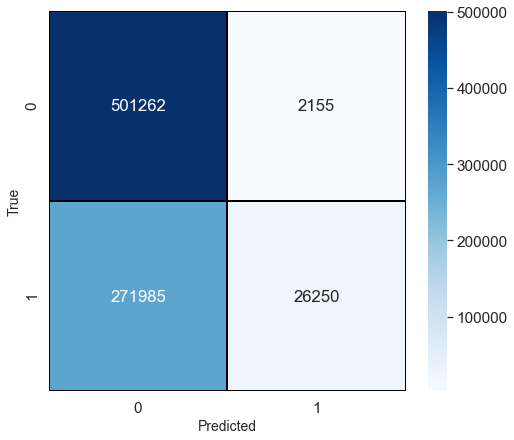

In [197]:
conf_matrix(cm_m1)

In [198]:
model_metrics(y_test, y_pred_m1)

Accuracy: 65.8 %
Precision score: 92.41 %
Recall score: 8.8 %
F1 score: 16.07 %


## Model 2

In [61]:
model_2 = Sequential()

model_2.add(Dense(30, activation='tanh', input_shape=(62,)))

model_2.add(Dense(10, activation='tanh'))

model_2.add(Dense(1, activation='sigmoid'))

In [62]:
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [63]:
results2 = model_2.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

Train on 2885944 samples, validate on 320661 samples
Epoch 1/5
2885944/2885944 [==============================] - 132s 46us/step - loss: 0.6168 - acc: 0.6763 - val_loss: 0.6077 - val_acc: 0.6781
Epoch 2/5
2885944/2885944 [==============================] - 122s 42us/step - loss: 0.6100 - acc: 0.6795 - val_loss: 0.6036 - val_acc: 0.6880
Epoch 3/5
2885944/2885944 [==============================] - 167s 58us/step - loss: 0.6085 - acc: 0.6788 - val_loss: 0.6056 - val_acc: 0.6877
Epoch 4/5
2885944/2885944 [==============================] - 196s 68us/step - loss: 0.6081 - acc: 0.6783 - val_loss: 0.6015 - val_acc: 0.6851
Epoch 5/5
2885944/2885944 [==============================] - 147s 51us/step - loss: 0.6080 - acc: 0.6786 - val_loss: 0.6056 - val_acc: 0.6883


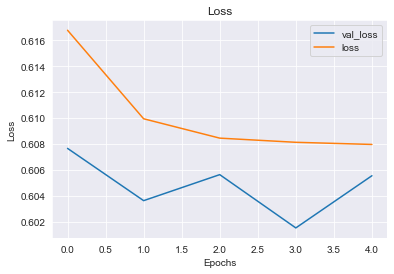

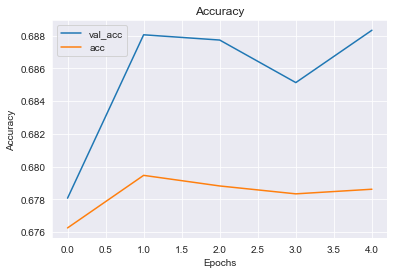

In [80]:
visualize_training_results(results2)

In [199]:
y_pred_m2 = model_2.predict(X_test)
y_pred_m2 =(y_pred_m1 > 0.5)

In [200]:
cm_m2 = confusion_matrix(y_test, y_pred_m2)
print(cm_m2)
print("------------------")
print(classification_report(y_test, y_pred_m2))

[[501262   2155]
 [271985  26250]]
------------------
              precision    recall  f1-score   support

         0.0       0.65      1.00      0.79    503417
         1.0       0.92      0.09      0.16    298235

    accuracy                           0.66    801652
   macro avg       0.79      0.54      0.47    801652
weighted avg       0.75      0.66      0.55    801652



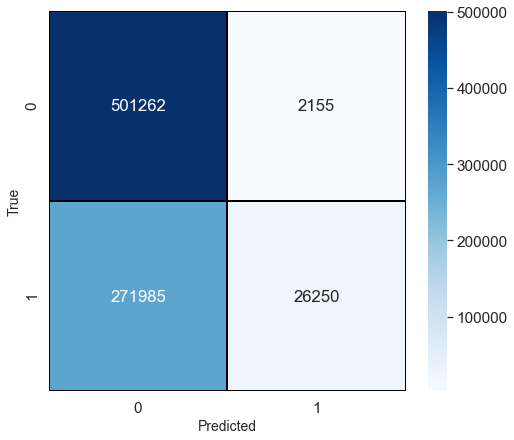

In [201]:
conf_matrix(cm_m1)

In [202]:
model_metrics(y_test, y_pred_m2)

Accuracy: 65.8 %
Precision score: 92.41 %
Recall score: 8.8 %
F1 score: 16.07 %


## Model 3

In [64]:
model_3 = Sequential()

model_3.add(Dense(30, activation='relu', input_shape=(62,)))

model_3.add(Dense(10, activation='relu'))

model_3.add(Dense(5, activation='relu'))

model_3.add(Dense(1, activation='sigmoid'))

In [65]:
model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [66]:
results3 = model_3.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

Train on 2885944 samples, validate on 320661 samples
Epoch 1/5
2885944/2885944 [==============================] - 114s 40us/step - loss: 0.6060 - acc: 0.6791 - val_loss: 0.5916 - val_acc: 0.6871
Epoch 2/5
2885944/2885944 [==============================] - 117s 41us/step - loss: 0.5916 - acc: 0.6895 - val_loss: 0.5862 - val_acc: 0.6937
Epoch 3/5
2885944/2885944 [==============================] - 118s 41us/step - loss: 0.5887 - acc: 0.6915 - val_loss: 0.5875 - val_acc: 0.6935
Epoch 4/5
2885944/2885944 [==============================] - 118s 41us/step - loss: 0.5873 - acc: 0.6925 - val_loss: 0.5837 - val_acc: 0.6948
Epoch 5/5
2885944/2885944 [==============================] - 117s 41us/step - loss: 0.5862 - acc: 0.6935 - val_loss: 0.5864 - val_acc: 0.6943


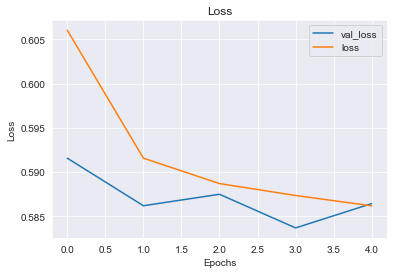

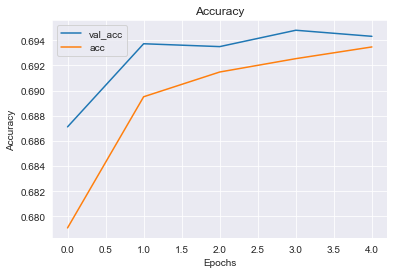

In [79]:
visualize_training_results(results3)

In [203]:
y_pred_m3 = model_3.predict(X_test)
y_pred_m3 =(y_pred_m3 > 0.5)

In [207]:
cm_m3 = confusion_matrix(y_test, y_pred_m3)
print(cm_m3)
print("------------------")
print(classification_report(y_test, y_pred_m3))

[[451652  51765]
 [193486 104749]]
------------------
              precision    recall  f1-score   support

         0.0       0.70      0.90      0.79    503417
         1.0       0.67      0.35      0.46    298235

    accuracy                           0.69    801652
   macro avg       0.68      0.62      0.62    801652
weighted avg       0.69      0.69      0.67    801652



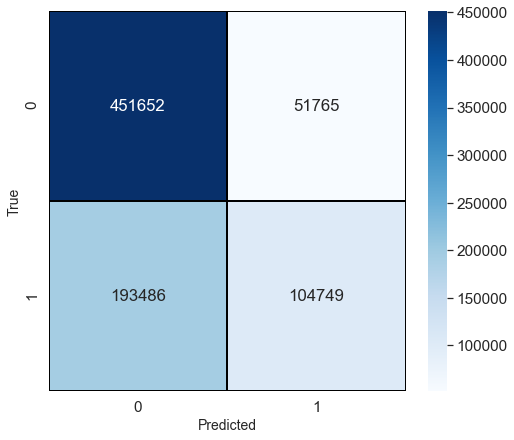

In [214]:
conf_matrix(cm_m3)

In [220]:
model_metrics(y_test, y_pred_m3)

Accuracy: 69.41 %
Precision score: 66.93 %
Recall score: 35.12 %
F1 score: 46.07 %


## Model 4

In [70]:
model_4 = Sequential()

model_4.add(Dense(30, activation='relu', input_shape=(62,)))

model_4.add(Dense(10, activation='relu'))

model_4.add(Dense(5, activation='relu'))

model_4.add(Dense(1, activation='sigmoid'))

In [71]:
model_4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [72]:
results4 = model_4.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Train on 2885944 samples, validate on 320661 samples
Epoch 1/10
2885944/2885944 [==============================] - 124s 43us/step - loss: 0.6093 - acc: 0.6742 - val_loss: 0.5904 - val_acc: 0.6914
Epoch 2/10
2885944/2885944 [==============================] - 126s 44us/step - loss: 0.5919 - acc: 0.6892 - val_loss: 0.5904 - val_acc: 0.6881
Epoch 3/10
2885944/2885944 [==============================] - 133s 46us/step - loss: 0.5896 - acc: 0.6910 - val_loss: 0.5847 - val_acc: 0.6944
Epoch 4/10
2885944/2885944 [==============================] - 125s 43us/step - loss: 0.5881 - acc: 0.6923 - val_loss: 0.5835 - val_acc: 0.6953
Epoch 5/10
2885944/2885944 [==============================] - 126s 44us/step - loss: 0.5870 - acc: 0.6932 - val_loss: 0.5855 - val_acc: 0.6941
Epoch 6/10
2885944/2885944 [==============================] - 133s 46us/step - loss: 0.5862 - acc: 0.6937 - val_loss: 0.5871 - val_acc: 0.6924
Epoch 7/10
2885944/2885944 [==============================] - 128s 44us/step - loss: 0.58

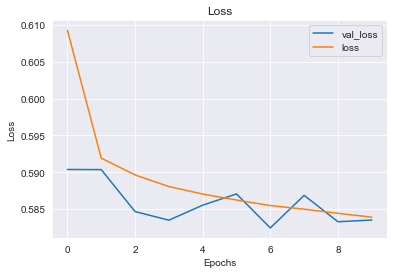

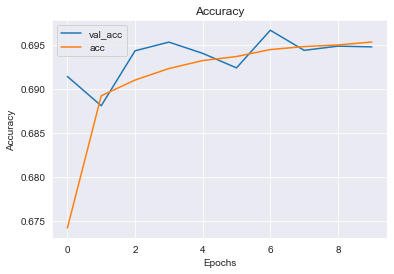

In [78]:
visualize_training_results(results4)

In [204]:
y_pred_m4 = model_4.predict(X_test)
y_pred_m4 =(y_pred_m4 > 0.5)

In [208]:
cm_m4 = confusion_matrix(y_test, y_pred_m4)
print(cm_m4)
print("------------------")
print(classification_report(y_test, y_pred_m4))

[[465574  37843]
 [206819  91416]]
------------------
              precision    recall  f1-score   support

         0.0       0.69      0.92      0.79    503417
         1.0       0.71      0.31      0.43    298235

    accuracy                           0.69    801652
   macro avg       0.70      0.62      0.61    801652
weighted avg       0.70      0.69      0.66    801652



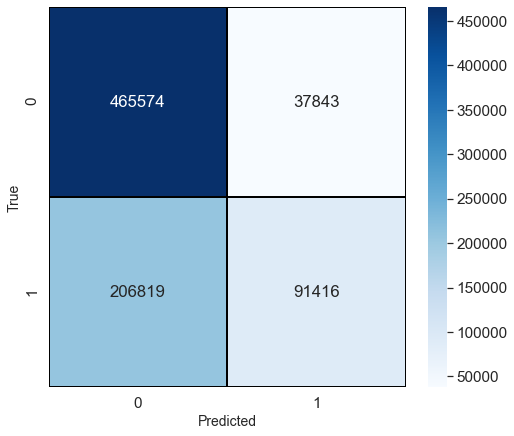

In [215]:
conf_matrix(cm_m4)

In [221]:
model_metrics(y_test, y_pred_m4)

Accuracy: 69.48 %
Precision score: 70.72 %
Recall score: 30.65 %
F1 score: 42.77 %


## Model 5

In [85]:
model_5 = Sequential()

model_5.add(Dense(30, activation='relu', input_shape=(62,)))

model_5.add(Dense(20, activation='relu'))

model_5.add(Dense(5, activation='relu'))

model_5.add(Dense(1, activation='sigmoid'))

In [86]:
model_5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [87]:
results5 = model_5.fit(X_train, y_train, epochs=2, batch_size=32, validation_split=0.1)

Train on 2885944 samples, validate on 320661 samples
Epoch 1/2
2885944/2885944 [==============================] - 122s 42us/step - loss: 0.6048 - acc: 0.6801 - val_loss: 0.5892 - val_acc: 0.6915
Epoch 2/2
2885944/2885944 [==============================] - 124s 43us/step - loss: 0.5905 - acc: 0.6900 - val_loss: 0.5875 - val_acc: 0.6937


In [205]:
y_pred_m5 = model_5.predict(X_test)
y_pred_m5 =(y_pred_m1 > 0.5)

In [209]:
cm_m5 = confusion_matrix(y_test, y_pred_m5)
print(cm_m5)
print("------------------")
print(classification_report(y_test, y_pred_m5))

[[501262   2155]
 [271985  26250]]
------------------
              precision    recall  f1-score   support

         0.0       0.65      1.00      0.79    503417
         1.0       0.92      0.09      0.16    298235

    accuracy                           0.66    801652
   macro avg       0.79      0.54      0.47    801652
weighted avg       0.75      0.66      0.55    801652



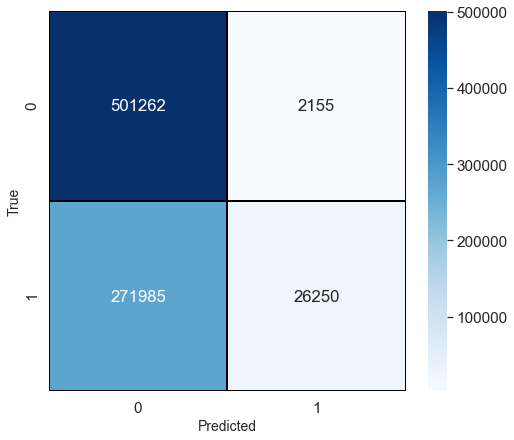

In [216]:
conf_matrix(cm_m5)

In [222]:
model_metrics(y_test, y_pred_m5)

Accuracy: 65.8 %
Precision score: 92.41 %
Recall score: 8.8 %
F1 score: 16.07 %


## Model 6

In [133]:
model_6 = Sequential()

model_6.add(Dense(50, activation='relu', input_shape=(62,)))

model_6.add(Dense(40, activation='relu'))

model_6.add(Dense(30, activation='relu'))

model_6.add(Dense(5, activation='relu'))

model_6.add(Dense(1, activation='sigmoid'))

In [134]:
model_6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [135]:
results6 = model_6.fit(X_train, y_train, epochs=2, batch_size=32, validation_split=0.1)

Train on 2885944 samples, validate on 320661 samples
Epoch 1/2
2885944/2885944 [==============================] - 190s 66us/step - loss: 0.6046 - acc: 0.6806 - val_loss: 0.6012 - val_acc: 0.6825
Epoch 2/2
2885944/2885944 [==============================] - 192s 67us/step - loss: 0.5918 - acc: 0.6888 - val_loss: 0.5888 - val_acc: 0.6914


In [206]:
y_pred_m6 = model_6.predict(X_test)
y_pred_m6 =(y_pred_m6 > 0.5)

In [218]:
cm_m6 = confusion_matrix(y_test, y_pred_m6)
print(cm_m6)
print("------------------")
print(classification_report(y_test, y_pred_m6))

[[444012  59405]
 [188020 110215]]
------------------
              precision    recall  f1-score   support

         0.0       0.70      0.88      0.78    503417
         1.0       0.65      0.37      0.47    298235

    accuracy                           0.69    801652
   macro avg       0.68      0.63      0.63    801652
weighted avg       0.68      0.69      0.67    801652



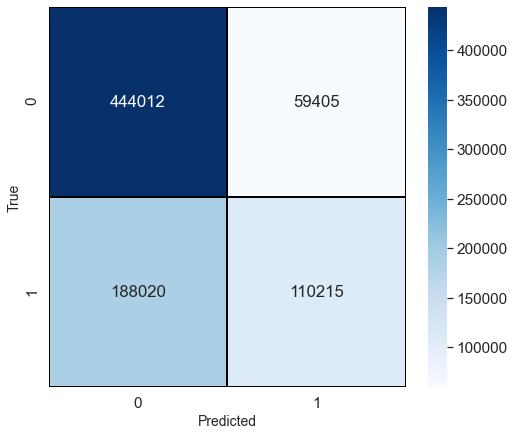

In [219]:
conf_matrix(cm_m6)

In [223]:
model_metrics(y_test, y_pred_m6)

Accuracy: 69.14 %
Precision score: 64.98 %
Recall score: 36.96 %
F1 score: 47.12 %


## Model 7

In [159]:
model_7 = Sequential()

model_7.add(Dense(30, activation='relu', input_shape=(62,)))

model_7.add(Dense(10, activation='relu'))

model_7.add(Dense(5, activation='relu'))

model_7.add(Dense(1, activation='sigmoid'))

In [160]:
model_7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [161]:
results7 = model_7.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.1)

Train on 2885944 samples, validate on 320661 samples
Epoch 1/25
2885944/2885944 [==============================] - 170s 59us/step - loss: 0.6131 - acc: 0.6770 - val_loss: 0.5933 - val_acc: 0.6904
Epoch 2/25
2885944/2885944 [==============================] - 153s 53us/step - loss: 0.5924 - acc: 0.6887 - val_loss: 0.5865 - val_acc: 0.6930
Epoch 3/25
2885944/2885944 [==============================] - 147s 51us/step - loss: 0.5894 - acc: 0.6910 - val_loss: 0.5844 - val_acc: 0.6945
Epoch 4/25
2885944/2885944 [==============================] - 157s 54us/step - loss: 0.5879 - acc: 0.6922 - val_loss: 0.5849 - val_acc: 0.6945
Epoch 5/25
2885944/2885944 [==============================] - 162s 56us/step - loss: 0.5870 - acc: 0.6925 - val_loss: 0.5844 - val_acc: 0.6942
Epoch 6/25
2885944/2885944 [==============================] - 216s 75us/step - loss: 0.5864 - acc: 0.6931 - val_loss: 0.5845 - val_acc: 0.6940
Epoch 7/25
2885944/2885944 [==============================] - 268s 93us/step - loss: 0.58

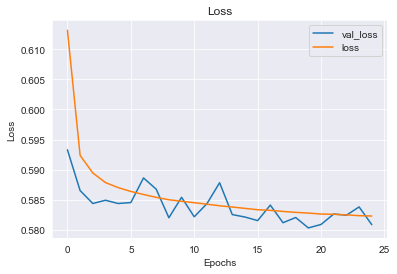

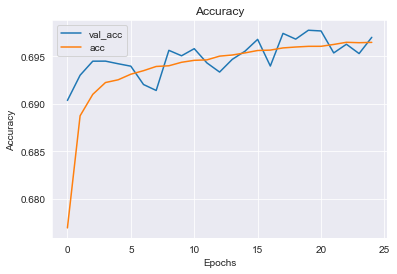

In [162]:
visualize_training_results(results7)

In [210]:
y_pred_m7 = model_7.predict(X_test)
y_pred_m7 =(y_pred_m7 > 0.5)

In [211]:
cm_m7 = confusion_matrix(y_test, y_pred_m7)
print(cm_m7)
print("------------------")
print(classification_report(y_test, y_pred_m7))

[[452325  51092]
 [192046 106189]]
------------------
              precision    recall  f1-score   support

         0.0       0.70      0.90      0.79    503417
         1.0       0.68      0.36      0.47    298235

    accuracy                           0.70    801652
   macro avg       0.69      0.63      0.63    801652
weighted avg       0.69      0.70      0.67    801652



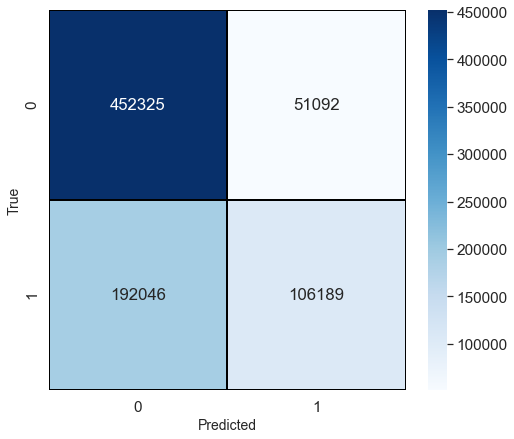

In [212]:
conf_matrix(cm_m7)

In [213]:
model_metrics(y_test, y_pred_m7)

Accuracy: 69.67 %
Precision score: 67.52 %
Recall score: 35.61 %
F1 score: 46.62 %
